In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 58.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU is active: {device_name}")
else:
    print("No GPU detected")


GPU is active: /device:GPU:0


In [ ]:
# Import libraries
from nilearn import datasets
import nilearn.datasets
from nilearn.datasets import fetch_oasis_vbm
from nilearn.image import load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import optuna
import cv2
import warnings
from tensorflow.keras import layers, models, Input, Model
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


**Pre-Processing**

In [ ]:
# Import the necessary libraries
import nibabel as nib
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns

In [ ]:
# Fetch the Oasis VBM dataset
oasis_data=nilearn.datasets.fetch_oasis_vbm(n_subjects=None, dartel_version=True, data_dir=None, url=None, resume=True, verbose=1)

[get_dataset_dir] Dataset found in /root/nilearn_data/oasis1

In [ ]:
# Load the DataFrame with clinical and demographic variables
ext_vars = pd.DataFrame(oasis_data['ext_vars'])

**CNN+XGBoost**

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.8 MB/s eta 0:00:00


In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# CNN+XGBOOST model is taken from Ren, X., Guo, H., Li, S., Wang, S., & Li, J. (2017). A novel image classification method with CNN-XGBoost model.
# In Digital Forensics and Watermarking: 16th International Workshop, IWDW 2017, Magdeburg, Germany, August 23-25, 2017, Proceedings 16 (pp. 378-390). Springer International Publishing.

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
img_size = 64

# Load 2D slice extraction
def extract_2d_slice_from_nifti(paths, img_size):
    slices = []
    for path in paths:
        img_3d = load_img(path).get_fdata()
        if img_3d.ndim == 3:
            z_center = img_3d.shape[2] // 2
            img_2d = img_3d[:, :, z_center]
            img_resized = cv2.resize(img_2d, (img_size, img_size), interpolation=cv2.INTER_AREA)
            slices.append(img_resized)
    return np.array(slices)

# Load images and 'cdr' scores
X = extract_2d_slice_from_nifti(oasis_data['gray_matter_maps'], img_size)

# Standardize each image
X = np.array([(img - np.mean(img)) / (np.std(img) + 1e-8) for img in X], dtype=np.float32)

# Convert 'cdr' into a binary variable (0.0 == 0, 0.5/1.0/2.0 == 1)
ext_vars['cdr'] = ext_vars['cdr'].apply(lambda x: 0 if x == 0.0 else 1).astype(int)
y = ext_vars['cdr'].values
X = X[..., np.newaxis]  # Add channel


In [ ]:
# Split the data into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split the train+val set into separate train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

In [ ]:
# Build the CNN+XGBoost Model
def build_cnn_model(n_filters1, n_filters2, input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(n_filters1, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(n_filters2, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten(name='flatten_layer')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the Feature Extractor
def create_feature_extractor(trained_model):
    return Model(inputs=trained_model.input,
                 outputs=trained_model.get_layer('flatten_layer').output)


In [ ]:
# Define the Optuna objective function
def objective(trial):

    # CNN hyperparameters
    n_filters1 = trial.suggest_int("n_filters1", 22, 40, step=2)
    n_filters2 = trial.suggest_int("n_filters2", 24, 72, step=8)

    # XGBoost hyperparameters
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 300, 400, 500])
    max_depth = trial.suggest_categorical("max_depth", [4, 6, 8, 10, 12])
    learning_rate = trial.suggest_categorical("learning_rate", [0.005, 0.01, 0.05, 0.1, 0.2])

    # Cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_accuracies = []

    for train_idx, val_idx in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Build and train the CNN
        cnn = build_cnn_model(n_filters1, n_filters2)
        cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = cnn.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=30, batch_size=32,
            verbose=0)

        # Extract the validation accuracy directly
        val_acc = history.history['val_accuracy'][-1]
        val_accuracies.append(val_acc)

        # Feature extraction
        X_fold_train_feat = extract_features(cnn, X_fold_train)
        X_fold_val_feat = extract_features(cnn, X_fold_val)

        # Check class balance
        if len(np.unique(y_fold_train)) < 2 or len(np.unique(y_fold_val)) < 2:
            raise optuna.exceptions.TrialPruned()

        # Fit XGBoost
        xgb_model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            use_label_encoder=False,
            eval_metric='logloss',
            verbosity=0,
            tree_method='gpu_hist',
            n_jobs=-1)
        xgb_model.fit(X_fold_train_feat, y_fold_train)
    return np.mean(val_accuracies)


In [ ]:
# Create the study and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=1)
print("Best hyperparameters:", study.best_trial.params)


Best hyperparameters: {'n_filters1': 40, 'n_filters2': 24, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.01}


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

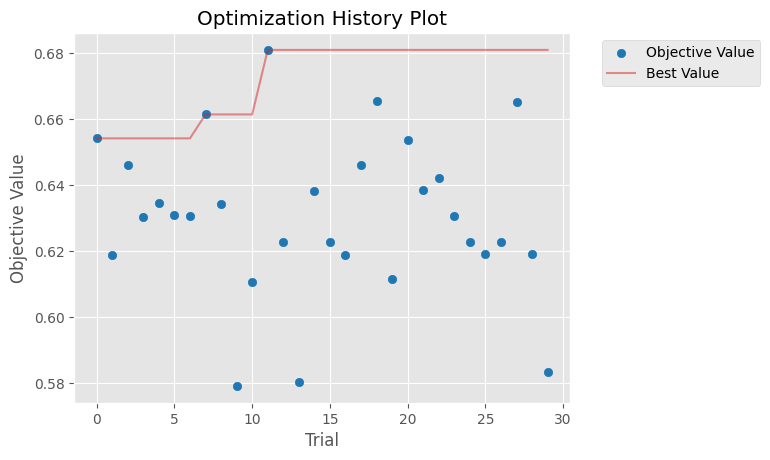

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study)

In [ ]:
cnnxgboost_params = study.best_params
print(cnnxgboost_params)

{'n_filters1': 40, 'n_filters2': 24, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.01}


In [ ]:
final_params_cnnxgboost = dict(n_filters1=cnnxgboost_params['n_filters1'], n_filters2 = cnnxgboost_params['n_filters2'],
                        n_estimators = cnnxgboost_params['n_estimators'], max_depth = cnnxgboost_params['max_depth'], learning_rate = cnnxgboost_params['learning_rate'])

In [ ]:
# Re-define the CNN+XGBoost architecture
def build_cnn_model(n_filters1, n_filters2, input_shape=(64, 64, 1)):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(n_filters1, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(n_filters2, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten(name='flatten_layer')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Feature Extractor
def create_feature_extractor(trained_model):
    return Model(inputs=trained_model.input,
                 outputs=trained_model.get_layer('flatten_layer').output)



In [ ]:
# Retrain the model with the best hyperparameters found
final_params_cnnxgboost = {
    'n_filters1': 40,
    'n_filters2': 24,
    'n_estimators': 400,
    'max_depth': 10,
    'learning_rate': 0.01}

cnn_final = build_cnn_model(final_params_cnnxgboost['n_filters1'], final_params_cnnxgboost['n_filters2'])
cnn_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_final.fit(X_trainval, y_trainval, validation_split=0.2, epochs=30, batch_size=32, verbose=1)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5388 - loss: 0.7560 - val_accuracy: 0.7077 - val_loss: 0.6599
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6871 - loss: 0.6467 - val_accuracy: 0.7077 - val_loss: 0.6064
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6871 - loss: 0.6241 - val_accuracy: 0.7077 - val_loss: 0.6037
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6871 - loss: 0.6068 - val_accuracy: 0.7077 - val_loss: 0.6028
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6871 - loss: 0.6051 - val_accuracy: 0.7077 - val_loss: 0.5989
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6871 - loss: 0.5935 - val_accuracy: 0.7077 - val_loss: 0.5982
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6871 - loss: 0.5901 - val_accuracy: 0.7231 - val_loss: 0.5968
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6893 - loss: 0.5787 - val_accuracy: 0.7231 - val_loss: 0.5910


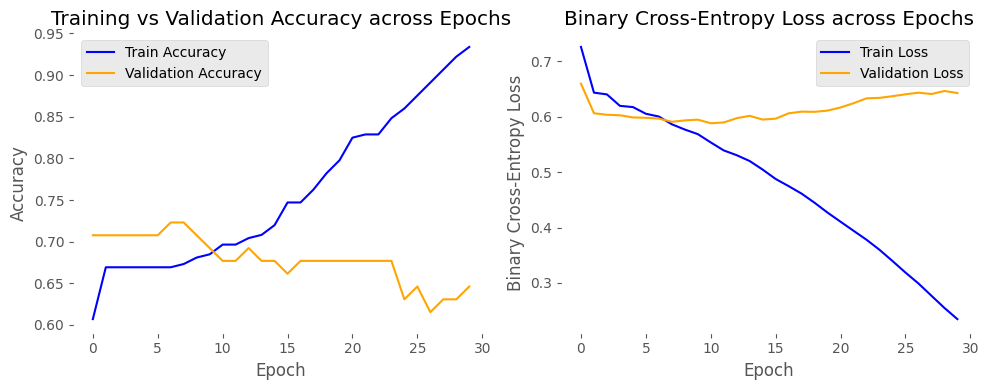

In [ ]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy
fig = plt.figure(figsize=(10, 4), facecolor='white')

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy across Epochs')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('white')

# Plot Binary Cross-Entropy Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Binary Cross-Entropy Loss across Epochs')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig("cnn_training_plots.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()


In [ ]:
# Extract the Features from the CNN to make the final classification using XGBoost
feature_extractor_final = create_feature_extractor(cnn_final)
X_trainval_feat = feature_extractor_final.predict(X_trainval, batch_size=32, verbose=0)
X_test_feat = feature_extractor_final.predict(X_test, batch_size=32, verbose=0)

# Train the final XGBoost Classifier
xgb_final = XGBClassifier(
    n_estimators=final_params_cnnxgboost['n_estimators'],
    max_depth=final_params_cnnxgboost['max_depth'],
    learning_rate=final_params_cnnxgboost['learning_rate'],
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=1,
    tree_method='gpu_hist',
    n_jobs=-1)

xgb_final.fit(X_trainval_feat, y_trainval)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute the Evaluation Metrics and print them
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    print("\n Binary Classification Evaluation")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Build the Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plot the ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


FINAL CNN + XGBOOST MODEL EVALUATION ON TEST SET

 Binary Classification Evaluation
Accuracy:             0.6667
Balanced Accuracy:    0.5517
Precision:            0.7059
Recall (Sensitivity): 0.8727
F1 Score:             0.7805
Log Loss:             0.6580
Brier Score:          0.2252
AUC-ROC:              0.6692

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.46      0.23      0.31        26
    Demented       0.71      0.87      0.78        55

    accuracy                           0.67        81
   macro avg       0.58      0.55      0.54        81
weighted avg       0.63      0.67      0.63        81



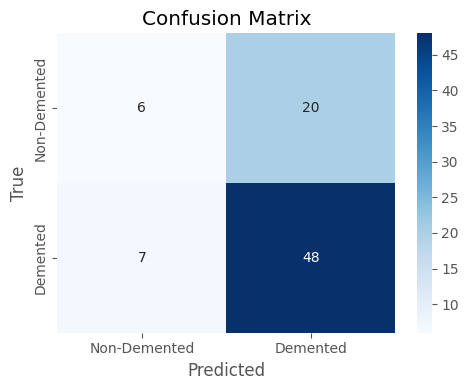

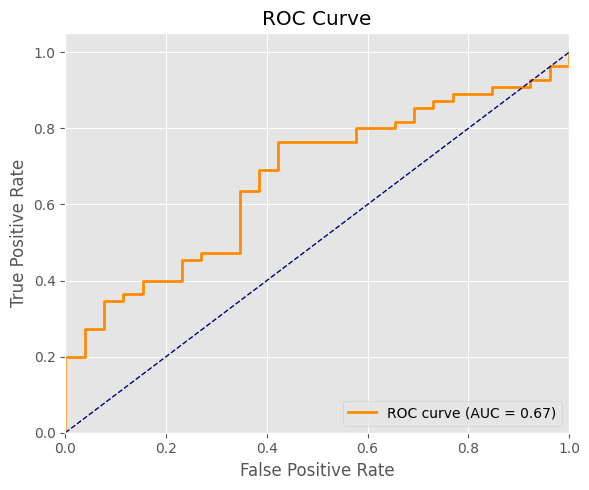

In [ ]:
# Predict on the test set using XGBoost
y_test_pred = xgb_final.predict(X_test_feat)  # Predicted class labels (0/1)
y_test_proba = xgb_final.predict_proba(X_test_feat)[:, 1]  # Probabilities for class 1 (Demented)

# Print header
print("FINAL CNN + XGBOOST MODEL EVALUATION ON TEST SET")

# Evaluate and visualize
evaluate_model(
    y_true=y_test,
    y_pred=y_test_pred,
    y_proba=y_test_proba,
    class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix plot
plt.savefig("confusion_matrix_default_threshold.png", dpi=300)
plt.close()



EVALUATION WITH OPTIMAL THRESHOLD (0.1936)

 Binary Classification Evaluation
Accuracy:             0.6790
Balanced Accuracy:    0.5000
Precision:            0.6790
Recall (Sensitivity): 1.0000
F1 Score:             0.8088
Log Loss:             0.6580
Brier Score:          0.2252
AUC-ROC:              0.6692

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.00      0.00      0.00        26
    Demented       0.68      1.00      0.81        55

    accuracy                           0.68        81
   macro avg       0.34      0.50      0.40        81
weighted avg       0.46      0.68      0.55        81



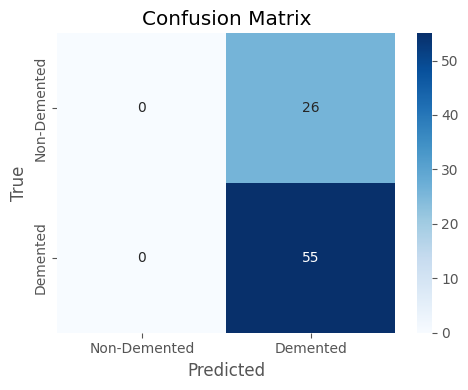

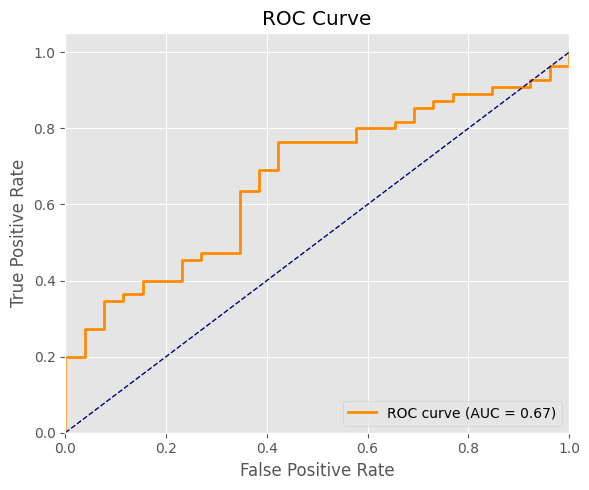

In [ ]:
# Get the predicted probabilities for the positive class (Demented)
y_test_proba = xgb_final.predict_proba(X_test_feat)[:, 1]

# Compute the optimal threshold based on F1 score
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nEVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

# Convert probabilities to binary predictions based on optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate model performance with optimal threshold
evaluate_model(
    y_true=y_test,
    y_pred=y_test_pred_optimal,
    y_proba=y_test_proba,
    class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix plot
plt.savefig("confusion_matrix_optimal_threshold.png", dpi=300)
plt.close()
